In [1]:
import sys
import os
import requests
import datetime
from pathlib import Path
#
path_root = Path(os.path.abspath(''))
sys.path.insert(1, os.path.join(path_root))
#
path_root2 = Path(os.path.abspath('')).parent
sys.path.insert(1, os.path.join(path_root2))

import time
import talib
import sqlite3 as sqlite3
import numpy as np
import pandas as pd
import json
import imgkit
imgkit.config(wkhtmltoimage='./wkhtmltoimage.exe')
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
prop = fm.FontProperties(fname='DejaVuSansYuanTi-Regular.ttf')
from scipy import stats
from util.util import get_ucodes
from pypfopt import risk_models, expected_returns, efficient_frontier, plotting, objective_functions

path_sqlite = os.path.join(path_root, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
if not os.path.exists(path_sqlite):
    path_sqlite = os.path.join(path_root2, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')

cur_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
temp_path = os.path.join(path_root, '現代資產組合', cur_time)
Path(temp_path).mkdir(parents=True, exist_ok=True)

pd.options.mode.chained_assignment = None

In [2]:
# 繪圖
def draw_table(data, title, scale_x=2, scale_y=1.5, is_show=False):
    ax = plt.subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    table = pd.plotting.table(ax, data, loc='center')
    table.auto_set_column_width(col=list(range(len(data.columns))))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(scale_x, scale_y)
    plt.savefig(os.path.join(temp_path, title), bbox_inches="tight")
    if not is_show:
        plt.clf()
    
def draw_stats(data, title, scale_x, scale_y, is_show):
    data3 = pd.DataFrame(columns=['underlying', 'skewness', 'kurtosis', 'min', 'max', 'median', 'mean', 'sd'])
    data3['underlying'] = data.columns.values[1:]
    data3['sd'] = data.std().to_list()

    data4 = data.copy(deep=True)
    del data4['Date']
    stats3 = stats.describe(data4.values)
    data3['min'] = stats3.minmax[0]
    data3['max'] = stats3.minmax[1]
    data3['mean'] = stats3.mean
    data3['skewness'] = stats3.skewness
    data3['kurtosis'] = stats3.kurtosis

    data5 = data4.quantile([.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).values.tolist()
    data3['median'] = data5[5]
    data3['sharpe'] = data3['mean'] / data3['sd']
    
    data3 = data3.sort_values(by=['sharpe', 'sd'])
    draw_table(data=data3.round(2), title=f'{title}.png', scale_x=1.5, scale_y=1.5, is_show=True)
    return data3

In [3]:
conn = sqlite3.connect(path_sqlite)
cursor = conn.cursor()

data = {}
ucodes = ['hsi', '02800', 'hsce', 'ssec', '000016','ixic', 'sp500', 'spy', 'n225', 'twii', 'ks11', 'gdaxi', 'fchi', 'ftse', 'shy', 'ief', 'tlt'] # 'cclhk', 'xin9x000', '02823'
for ucode in ucodes:
    if '.HK' in ucode:
        ucode = ucode.replace('.HK', '').zfill(5)
    if '.SS' in ucode or '.SZ' in ucode:
        ucode = ucode.replace('.SS', '').replace('.SZ', '').zfill(6)
    
    #
    sql = """SELECT t.code, t.lot, t.nmll, t.stime, t.high, t.low, t.open, t.close, t.volume
                FROM (SELECT n.code, n.lot, n.nmll, c.stime, c.high, c.low, c.open, c.close, c.volume 
                    FROM s_{} AS c INNER JOIN name AS n 
                        ON c.code=n.code ORDER BY c.stime DESC) AS t 
                            ORDER BY t.stime """.format(ucode)
    cursor.execute(sql)
    columns = ['code', 'lot', 'nmll', 'sdate', 'high', 'low', 'open', 'last', 'vol']
    data[ucode] = pd.DataFrame(cursor.fetchall(), columns=columns)
    data[ucode].index = pd.to_datetime(data[ucode].sdate)
    print(f"{ucode}:   {data[ucode].index[0]} ~ {data[ucode].index[-1]}  {data[ucode].shape}")
conn.close()

hsi:   1986-12-31 00:00:00 ~ 2021-09-13 00:00:00  (8542, 9)
02800:   2000-01-03 00:00:00 ~ 2021-09-10 00:00:00  (5352, 9)
hsce:   1993-07-15 00:00:00 ~ 2021-09-13 00:00:00  (6903, 9)
ssec:   1992-05-08 00:00:00 ~ 2021-09-13 00:00:00  (7242, 9)
000016:   2004-01-02 00:00:00 ~ 2021-09-10 00:00:00  (4302, 9)
ixic:   1971-02-05 00:00:00 ~ 2021-09-12 00:00:00  (12410, 9)
sp500:   1927-12-30 00:00:00 ~ 2021-09-12 00:00:00  (19693, 9)
spy:   1993-01-29 00:00:00 ~ 2021-09-10 00:00:00  (7207, 9)
n225:   1965-01-05 00:00:00 ~ 2021-09-13 00:00:00  (13727, 9)
twii:   1990-01-04 00:00:00 ~ 2021-09-13 00:00:00  (7787, 9)
ks11:   1990-01-03 00:00:00 ~ 2021-09-13 00:00:00  (7820, 9)
gdaxi:   1987-12-30 00:00:00 ~ 2021-09-12 00:00:00  (8497, 9)
fchi:   1990-03-01 00:00:00 ~ 2021-09-12 00:00:00  (8001, 9)
ftse:   1984-01-03 00:00:00 ~ 2021-09-12 00:00:00  (9580, 9)
shy:   2002-07-30 00:00:00 ~ 2021-09-10 00:00:00  (4814, 9)
ief:   2002-07-30 00:00:00 ~ 2021-09-10 00:00:00  (4814, 9)
tlt:   2002-07-30 00

In [4]:
data_all = []
nmll = []
for k, df in data.items():
    data_all.append(df['last'])
    nmll.append(k)
df2 = pd.concat(data_all, axis=1)
df2 = df2.dropna()
df2.columns = nmll
# df2 = df2.loc[(df2.index > '2009-01-01')]
print(f"{df2.index[0]} ~ {df2.index[-1]}  {df2.shape}")

2004-01-05 00:00:00 ~ 2021-09-10 00:00:00  (3620, 17)


In [5]:
start_year = list(dict.fromkeys(df2.index.year.values))[0]
end_year = list(dict.fromkeys(df2.index.year.values))[-1]
print(f'{start_year} ~ {end_year}')

2004 ~ 2021


相關系數 2004年起
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,hsi,02800,hsce,ssec,000016,ixic,sp500,spy,n225,twii,ks11,gdaxi,fchi,ftse,shy,ief,tlt
hsi,1.000000,1.000000,0.780000,0.720000,0.810000,0.690000,0.730000,0.730000,0.690000,0.800000,0.880000,0.850000,0.620000,0.850000,0.760000,0.720000,0.690000
02800,1.000000,1.000000,0.770000,0.720000,0.810000,0.690000,0.740000,0.730000,0.690000,0.790000,0.880000,0.860000,0.610000,0.850000,0.760000,0.730000,0.690000
hsce,0.780000,0.770000,1.000000,0.810000,0.760000,0.210000,0.230000,0.230000,0.190000,0.420000,0.620000,0.410000,0.250000,0.480000,0.550000,0.380000,0.290000
ssec,0.720000,0.720000,0.810000,1.000000,0.930000,0.390000,0.410000,0.410000,0.450000,0.540000,0.600000,0.550000,0.490000,0.480000,0.490000,0.410000,0.390000
000016,0.810000,0.810000,0.760000,0.930000,1.000000,0.630000,0.630000,0.630000,0.620000,0.730000,0.720000,0.690000,0.590000,0.540000,0.630000,0.570000,0.580000
ixic,0.690000,0.690000,0.210000,0.390000,0.630000,1.000000,0.990000,0.990000,0.890000,0.940000,0.810000,0.900000,0.660000,0.630000,0.730000,0.820000,0.870000
sp500,0.730000,0.740000,0.230000,0.410000,0.630000,0.990000,1.000000,1.000000,0.930000,0.940000,0.810000,0.940000,0.720000,0.730000,0.710000,0.820000,0.870000
spy,0.730000,0.730000,0.230000,0.410000,0.630000,0.990000,1.000000,1.000000,0.910000,0.940000,0.820000,0.940000,0.690000,0.710000,0.740000,0.850000,0.890000
n225,0.690000,0.690000,0.190000,0.450000,0.620000,0.890000,0.930000,0.910000,1.000000,0.850000,0.700000,0.890000,0.880000,0.760000,0.500000,0.630000,0.700000
twii,0.800000,0.790000,0.420000,0.540000,0.730000,0.940000,0.940000,0.940000,0.850000,1.000000,0.900000,0.900000,0.710000,0.700000,0.720000,0.770000,0.790000


<Figure size 432x288 with 0 Axes>

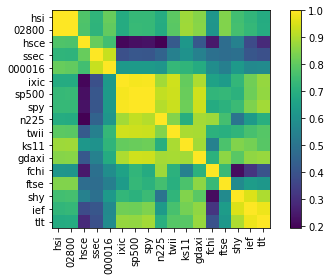

In [6]:
# 相關系數
print(f'相關系數 {start_year}年起')
df2_2 = df2.corr().round(2)
draw_table(data=df2_2, title='correlation_coefficient_2.png', scale_x=1.5, scale_y=1.5)
plotting.plot_covariance(df2.corr(), plot_correlation=False, filename=os.path.join(temp_path, 'correlation_coefficient_1.png'))

# df2_2 = df2_2.applymap(lambda x: 'green' if x<= 0.6 else (f'red' if x>=0.85 else ''))
#cm = sns.light_palette('green', as_cmap=True)
# df2_2.style.background_gradient(cmap=cm, low=0, high=1, axis=0)

def color_background(v):
    if v >= 0.8:
        return f'font-size: 9pt; background-color: #66c2a5'
    elif v <= 0.6:
        return f'font-size: 9pt; background-color: #fc8d62'
    else:
        return 'font-size: 9pt;'

df2_2 = df2_2.style.applymap(color_background)
df2_2 = df2_2.set_table_styles([{'selector': 'th', 'props': [('font-size', '8pt'), ('min-width', '30pt')]}])
imgkit.from_string(df2_2.render(), 'correlation_coefficient_3.png')
df2_2

均方差 2004年起      (3620, 17)


,hsi,02800,hsce,ssec,000016,ixic,sp500,spy,n225,twii,ks11,gdaxi,fchi,ftse,shy,ief,tlt
hsi,0.062323,0.060449,0.073965,0.034075,0.037915,0.018369,0.017113,0.017925,0.038584,0.033914,0.036869,0.025852,0.026697,0.023462,-0.000485,-0.002764,-0.005917
02800,0.060449,0.061081,0.071970,0.033110,0.036843,0.017811,0.016569,0.017366,0.037426,0.033129,0.035971,0.025377,0.026421,0.023243,-0.000500,-0.002740,-0.005921
hsce,0.073965,0.071970,0.101349,0.047811,0.053151,0.021719,0.019938,0.020852,0.046345,0.041296,0.044790,0.030885,0.031861,0.027786,-0.000623,-0.003505,-0.007247
ssec,0.034075,0.033110,0.047811,0.074438,0.074772,0.008406,0.007183,0.007418,0.019998,0.018393,0.018990,0.011048,0.011887,0.010994,-0.000155,-0.001206,-0.003078
000016,0.037915,0.036843,0.053151,0.074772,0.084487,0.009847,0.008541,0.008814,0.022247,0.020379,0.021555,0.012698,0.013588,0.012279,-0.000181,-0.001365,-0.003462
ixic,0.018369,0.017811,0.021719,0.008406,0.009847,0.054326,0.046732,0.046094,0.014361,0.013364,0.015004,0.033303,0.032742,0.026739,-0.001094,-0.006182,-0.013778
sp500,0.017113,0.016569,0.019938,0.007183,0.008541,0.046732,0.044771,0.044171,0.013530,0.011349,0.013848,0.031823,0.031712,0.026478,-0.001065,-0.006157,-0.013985
spy,0.017925,0.017366,0.020852,0.007418,0.008814,0.046094,0.044171,0.044086,0.014369,0.011760,0.014372,0.031895,0.031814,0.026650,-0.001037,-0.006031,-0.013735
n225,0.038584,0.037426,0.046345,0.019998,0.022247,0.014361,0.013530,0.014369,0.062355,0.030646,0.035611,0.024168,0.025350,0.020789,-0.000495,-0.002609,-0.005143
twii,0.033914,0.033129,0.041296,0.018393,0.020379,0.013364,0.011349,0.011760,0.030646,0.043131,0.032621,0.018150,0.019207,0.016707,-0.000337,-0.001725,-0.003762


<Figure size 432x288 with 0 Axes>

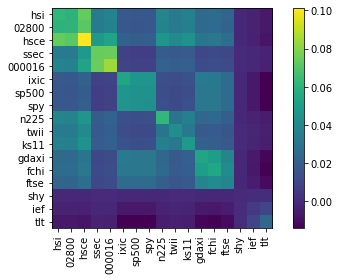

In [7]:
# 標準差
print(f'均方差 {start_year}年起      {df2.shape}')
draw_table(data=risk_models.sample_cov(df2).round(4), title='mean_square_error_2.png', scale_x=1.5, scale_y=1.5)
plotting.plot_covariance(risk_models.sample_cov(df2), plot_correlation=False, show_tickers=True, filename=os.path.join(temp_path, 'mean_square_error_1.png'))
risk_models.sample_cov(df2)

In [8]:
def simulate(df7):
    df7_1 = pd.DataFrame(columns=df7.columns)
    df7_1['Date'] = df7['Date']
    for v in df7.columns[1:]:
        cur_money = 10000
        no = 1
        for v1 in df7[v]:
            data2 = cur_money * (v1 / 100)
            cur_money = cur_money + data2
            df7_1.loc[no, v] = cur_money
            no = no + 1
    return df7_1

In [9]:
# inflation rate
cpi_data = {
    'hk': 'hk_cpi_1980',
    'china': 'china_cpi_1993',
    'us': 'us_cpi'
}
cpi = {}

for k, v in cpi_data.items():
    df8 = pd.read_csv(os.path.join(path_root, f'{v}.csv'))
    df8.Date = pd.to_datetime(df8.Date)
    df8.index = df8.Date
    df8.sort_index(inplace=True)
    
    #
    if k == 'china' or k == 'us':
        df8 = df8.groupby(df8['Date'].dt.year)['cpi'].agg(['sum', 'mean', 'max'])
        df8.columns = ['Date', 'cpi', 'max']
        del df8['max']
        df8.Date = [str(v2)+'-12-31' for v2 in df8.index.values]
    elif k == 'hk':
        df8.Date = df8.Date.dt.strftime('%Y-%m-%d')
    
    #
    no = 0
    for k1, v1 in df8.iterrows():
        if no < df8.shape[0] and no > 0:
            df8.loc[k1, 'Purchasing Power(%)'] = (df8.iloc[no-1].cpi - df8.iloc[no].cpi) / df8.iloc[no].cpi * 100
        no = no + 1
    df8['Inflation(%)'] = df8['cpi'].pct_change()*100
    df8.reset_index(drop=True, inplace=True)
    draw_table(data=df8.round(2), title=f'inflation_rate_{k}.png', scale_x=1.5, scale_y=1.5)
    cpi[k] = df8

<Figure size 432x288 with 0 Axes>

In [10]:
# 年度
df3_1 = df2.copy(deep=True)
df3 = pd.DataFrame(columns=['Date']+df3_1.columns.to_list())
for year in range(start_year, end_year+1, 1):
    df3_2 = df3_1[f'{year}-01-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df3.loc[df3.shape[0]+1] = [f'{year}-01-01 ~ {year}-12-31']+df3_2.iloc[-1].to_list()
    
# cpi
for k, df3_3 in cpi.items():
    df3_3.index = pd.to_datetime(df3_3.Date)
    df3_4 = df3_3[f'{start_year}-01-01': f'{end_year}-12-31']
    # df3[f'{k}_cpi'] = df3_4['Purchasing Power(%)'].values

#
print(f'年度收益率 标准差 (不同年份買入賣出, 收益的差距有多大) {start_year}年起')
df3_5 = draw_stats(data=df3, title=f'yearly_expected_return_stats', scale_x=1.5, scale_y=1.5, is_show=False)

#
print('年度收益率(回報)')
df3_2 = simulate(df3)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5.5), facecolor='white')
    
    ax1.barh(df3['Date'], df3[k], height=0.5, align='center')
    ax1.set_title(k+' Yearly Expected Return')
    ax1.grid()
    
    ax2.barh(df3_2['Date'], df3_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Yearly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_YearlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax = df3.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
    # ax2 = df3_2.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
    
draw_table(data=df3.round(2), title=f'yearly_expected_return.png', scale_x=1.5, scale_y=1.5)
#df3
df3_5

年度收益率 标准差 (不同年份買入賣出, 收益的差距有多大) 2004年起
年度收益率(回報)


d:\pycharmprojects\scrapy-001\venv\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


,underlying,skewness,kurtosis,min,max,median,mean,sd,sharpe
2,hsce,0.822262,0.613029,-49.984544,86.055627,-0.633487,6.242025,32.152221,0.194140
13,ftse,-1.179428,1.126516,-31.824427,17.868368,6.411488,2.655873,12.632057,0.210249
0,hsi,-0.352842,0.077747,-47.282012,39.036820,4.495214,5.515209,22.352992,0.246732
1,02800,-0.380689,0.136137,-47.395264,38.957816,4.484032,5.587082,22.242838,0.251186
12,fchi,-1.195664,1.208579,-42.585411,26.283904,7.984453,4.360170,17.131321,0.254515
3,ssec,0.877427,0.282602,-65.689554,117.415276,3.649795,12.390638,45.683016,0.271231
4,000016,0.889915,0.113388,-67.493381,131.929933,-1.419464,15.774404,51.549183,0.306007
9,twii,0.461015,2.300464,-43.981306,72.663754,8.872315,8.219808,23.492202,0.349895
8,n225,-0.103723,0.397578,-39.676977,52.424601,9.513207,8.081165,21.393254,0.377744
10,ks11,0.057441,0.065615,-38.967531,55.527112,6.584060,10.071030,22.648792,0.444661


<Figure size 432x288 with 0 Axes>

In [11]:
# 机會成本
df3_6 = df3_5.copy(deep=True)
df3_6.index = df3_6.underlying
df3_6 = df3_6[df3_6.index.isin(['hk_cpi', 'us_cpi', 'shy', 'tlt', 'cclhk', 'sp500', 'ixic', 'hsi', 'ief', 'ssec', '000016'])]
df3_6 = df3_6.rename(index={'hk_cpi': '現金(HKD)', 'us_cpi': '現金(USD)', 'shy': '短債(US)', 'ief': '中債(US)', 'tlt': '長債(US)', 'cclhk': '買房(HK)', 
                            'sp500': '股票(SP500)', 'ixic': '股票(IXIC)', 'hsi': '股票(HSI)', 'ssec': '股票(SSEC)', '000016': '股票(A50)'})

# 樂觀
df3_7 = df3_6.copy(deep=True).round(4)
del df3_7['underlying']
del df3_7['kurtosis']

df3_7 = df3_7.sort_values(by=['mean'], ascending=False)
print(f'樂觀視角(年度收益率) {start_year}年起')
print(df3_7)

print('---------------------------------------------------------------------------')
df3_7 = df3_7.sort_values(by=['min'], ascending=False)
print(f'風險視角(年度收益率) {start_year}年起')
print(df3_7)

樂觀視角(年度收益率) 2004年起
            skewness      min       max   median     mean       sd  sharpe
underlying                                                                
股票(A50)       0.8899 -67.4934  131.9299  -1.4195  15.7744  51.5492  0.3060
股票(IXIC)     -0.8232 -39.5741   41.8734  11.2841  13.1672  19.1836  0.6864
股票(SSEC)      0.8774 -65.6896  117.4153   3.6498  12.3906  45.6830  0.2712
股票(SP500)    -1.7511 -38.6081   27.2262  11.3893   8.7981  14.9833  0.5872
長債(US)        0.3920 -17.2734   34.4270   7.4932   7.4834  13.9185  0.5377
股票(HSI)      -0.3528 -47.2820   39.0368   4.4952   5.5152  22.3530  0.2467
中債(US)        0.3940  -4.7874   17.4600   3.9816   4.5886   6.1272  0.7489
短債(US)        1.3403  -0.0834    6.8384   1.1413   1.8653   2.0135  0.9264
---------------------------------------------------------------------------
風險視角(年度收益率) 2004年起
            skewness      min       max   median     mean       sd  sharpe
underlying                                                   

累計年化率 标准差 (不同年份買入持有, 收益的差距有多大) 2004年起


,underlying,skewness,kurtosis,min,max,median,mean,sd,sharpe
2,hsce,1.382304,1.873447,-52.146582,59.843196,-13.627080,-11.108875,26.457800,-0.419871
0,hsi,0.607079,-0.444334,-20.276594,56.243330,10.421674,13.015601,22.125044,0.588275
1,02800,0.602572,-0.451121,-18.473800,59.390113,12.904432,15.384055,22.629305,0.679829
13,ftse,0.738832,0.300427,-10.124907,44.919944,8.866245,10.364774,14.107985,0.734674
3,ssec,1.109520,0.617581,-38.312031,162.185914,20.592223,39.338563,52.366404,0.751218
4,000016,1.259257,0.860166,-31.831030,237.993534,38.107238,63.042337,74.807648,0.842726
15,ief,0.681432,-0.918299,-2.254316,107.639755,29.350954,42.877225,35.271393,1.215637
16,tlt,0.539695,-1.096803,-5.051279,190.526600,54.385102,76.075233,61.510174,1.236791
14,shy,1.064900,0.024522,-0.083392,37.835463,10.173107,14.253246,10.952392,1.301382
10,ks11,1.652540,2.588086,6.157688,252.859619,63.736711,81.566295,58.175722,1.402068


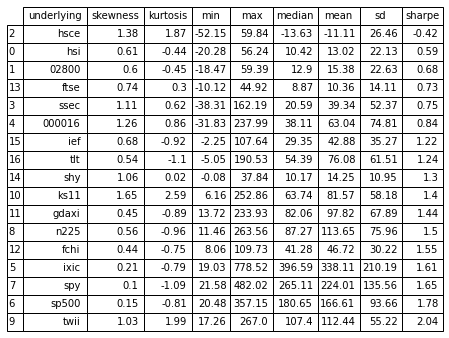

In [12]:
# 累計 年化收益率
df4_4 = pd.DataFrame(columns=df3.columns.to_list())

for i in range(1, df3.shape[0]):
    df4_3 = df3.copy(deep=True)
    df4_3 = df4_3.tail(i)
    df4 = pd.DataFrame(columns=df4_3.columns.to_list())
    
    # 年份
    start_year_4 = df4_3['Date'].iloc[0].split('~')[0].replace(' ', '')
    for k, v in df4_3.iterrows():
        end_year_4 = v['Date'].split('~')[1].replace(' ', '')
        df4_3.loc[k, 'Date'] = f'{start_year_4} ~ {end_year_4}'
    df4['Date'] = df4_3['Date']
    
    # 每產品
    for code in list(df4_3.columns.values)[1:]:
        annualized_total_return = 1
        annualized_total_returns = []
        # 每年
        for v in df4_3[code]:
            annualized_total_return = annualized_total_return * (1+(v/100))
            annualized_total_returns.append((annualized_total_return-1))
        df4[code] = annualized_total_returns

    for code in list(df4_3.columns.values)[1:]:
        df4[code] = df4[code]*100
        
    # 各x年 累計 年化收益率
    df4_4.loc[len(df4_4)] = df4.tail(1).values[0]
    
    # 繪圖
    no_year = df4.shape[0]
    draw_table(data=df4.round(2), title=f'annualized_return_nearly_{no_year}_years.png')

# 繪圖
df4_4.sort_values(by='Date', inplace=True)
draw_table(data=df4_4.round(2), title=f'annualized_return.png')

print(f'累計年化率 标准差 (不同年份買入持有, 收益的差距有多大) {start_year}年起')
df4_5 = draw_stats(data=df4_4, title=f'annualized_return_stats', scale_x=1.5, scale_y=1.5, is_show=False)

df4_5

每日收市價 标准差


,underlying,skewness,kurtosis,min,max,median,mean,sd,sharpe
13,ftse,-0.1929,9.2565,-10.8738,10.3227,0.0621,0.0200,1.2419,0.0161
2,hsce,0.0110,8.7975,-18.1948,16.8892,0.0324,0.0355,2.0054,0.0177
12,fchi,-0.1545,7.6663,-12.2768,11.3943,0.0699,0.0279,1.4764,0.0189
0,hsi,-0.0385,10.5106,-13.6666,14.3471,0.0700,0.0317,1.5726,0.0202
1,02800,-0.1983,7.8727,-13.4122,11.3793,0.0000,0.0320,1.5569,0.0205
3,ssec,-0.3445,4.9966,-11.9827,9.5886,0.0530,0.0386,1.7187,0.0224
8,n225,-0.5919,6.9594,-12.1241,9.9594,0.0636,0.0410,1.5730,0.0260
4,000016,-0.1655,4.2419,-12.3200,9.6729,0.0057,0.0478,1.8310,0.0261
9,twii,-0.5530,7.0888,-10.9049,9.6837,0.0793,0.0376,1.3083,0.0287
11,gdaxi,-0.1964,7.8244,-12.2386,11.2768,0.1033,0.0481,1.4610,0.0329


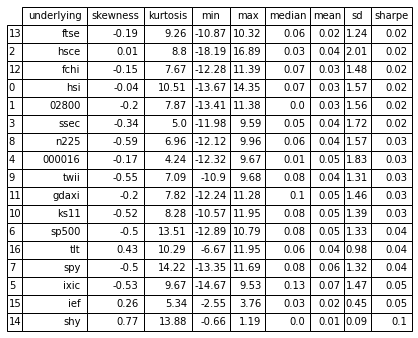

In [13]:
print("每日收市價 标准差")
df2_1 = df2.copy(deep=True)
df2_1 = df2_1.pct_change()*100
df2_1 = df2_1.reset_index()
df2_1 = df2_1.rename({'sdate': 'Date'}, axis=1)
df2_1.Date = df2_1.Date.astype('string')
df4_5 = draw_stats(data=df2_1.iloc[1:], title=f'daily_stats', scale_x=1.5, scale_y=1.5, is_show=False)
# df4_5['relative sd'] = df4_5['sd'] / df4_5['mean'] # 相对标准偏差
df4_5.round(4)

In [14]:
# 半年度
df5_1 = df2.copy(deep=True)
df5 = pd.DataFrame(columns=['Date']+df5_1.columns.to_list())
for year in range(start_year, 2022, 1):
    # 上半年
    df5_2 = df5_1[f'{year}-01-01': f'{year}-06-30'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-01-01 ~ {year}-06-30']+df5_2.iloc[-1].to_list()
    # 下半年
    df5_2 = df5_1[f'{year}-07-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-07-01 ~ {year}-12-31']+df5_2.iloc[-1].to_list()
print(f'半年度標準差(風險)  {start_year}年起')
print(df5.std())

df5_2 = simulate(df5)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10), facecolor='white')
    
    ax1.barh(df5['Date'], df5[k], height=0.5, align='center')
    ax1.set_title(k+' Semi yearly Expected Return')
    ax1.grid()
    
    ax2.barh(df5_2['Date'], df5_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Semi yearly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_SemiYearlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax1 = df5.plot.barh(x='Date', y=k, figsize=(6,8*1.4), grid=True)
    # ax2 = df5_2.plot.barh(x='Date', y=k, figsize=(6,8*1.4), grid=True)
print('半年度收益率(回報)')
df5

半年度標準差(風險)  2004年起
hsi       13.463502
02800     13.283183
hsce      17.706045
ssec      24.025446
000016    26.722213
ixic      11.816568
sp500     10.323996
spy       10.348329
n225      14.256139
twii      13.564140
ks11      13.674928
gdaxi     12.231393
fchi      12.234181
ftse       9.515280
shy        1.250190
ief        4.825040
tlt       10.894435
dtype: float64
半年度收益率(回報)


,Date,hsi,02800,hsce,ssec,000016,ixic,sp500,spy,n225,twii,ks11,gdaxi,fchi,ftse,shy,ief,tlt
1,2004-01-01 ~ 2004-06-30,-5.532963,-4.961832,-20.408137,-10.787816,-15.374608,0.021005,1.659211,2.588954,9.549044,-4.668750,-4.648708,0.417009,3.455929,-1.090105,0.023399,0.463556,1.310826
2,2004-07-01 ~ 2004-12-31,15.903431,14.516129,9.140820,-11.621019,-8.966812,8.555513,7.834691,8.585157,-1.985502,6.162832,18.598926,6.434730,3.877546,9.363802,0.538062,3.350771,6.854796
3,2005-01-01 ~ 2005-06-30,1.104658,2.482270,3.493590,-13.022163,-8.264587,-2.414778,0.276075,1.094838,0.575284,2.994487,13.672336,6.893830,9.475061,5.492061,1.096993,4.387538,12.109074
4,2005-07-01 ~ 2005-12-31,6.518960,5.574913,9.389517,12.590345,8.188558,6.706430,4.102113,4.896137,40.695722,5.511671,35.390308,18.570704,12.231619,8.635666,0.930442,-0.028624,0.055511
5,2006-01-01 ~ 2006-06-30,7.023397,7.166124,21.806319,41.597242,35.700230,-4.036735,-0.255996,0.825558,-5.233984,1.329560,-7.628500,2.891038,2.633862,2.078882,0.771947,-2.809505,-6.613806
6,2006-07-01 ~ 2006-12-31,22.510728,21.084337,52.578888,51.276807,54.365189,10.734885,11.290515,12.387511,10.616689,15.099072,10.802479,15.738997,11.097810,6.060093,2.844340,5.405081,7.915396
7,2007-01-01 ~ 2007-06-30,8.724593,9.429280,15.978962,40.688447,58.805339,6.105740,5.993627,7.063973,4.521749,11.956641,24.784399,19.970633,8.617184,5.104182,1.865438,-0.424613,-3.106101
8,2007-07-01 ~ 2007-12-31,25.695241,24.721604,31.770809,36.134993,44.103239,1.203807,-3.187155,-2.088730,-14.243659,-7.586336,5.711437,-0.150050,-7.287834,-2.138619,4.853013,8.906270,10.058653
9,2008-01-01 ~ 2008-06-30,-18.681294,-18.214936,-23.610106,-49.268883,-49.758133,-8.260984,-9.616013,-8.451815,-7.028492,-4.564412,-8.531296,-17.894585,-18.668837,-11.203186,1.566988,1.411367,-0.634984
10,2008-07-01 ~ 2008-12-31,-33.983672,-34.512472,-32.829412,-30.215995,-31.765593,-32.918197,-31.081555,-30.161146,-34.164336,-39.947717,-31.165929,-25.383877,-27.132909,-20.398797,4.497069,15.862254,33.646017


<Figure size 432x288 with 0 Axes>

In [15]:
# 季度
df7_1 = df2.copy(deep=True)
df7 = pd.DataFrame(columns=['Date']+df7_1.columns.to_list())
quarterly = [['01-01', '03-31'], ['04-01', '06-30'], ['07-01', '09-30'], ['10-01', '12-31']]
for year in range(start_year, 2022, 1):
    for v in quarterly:
        first = v[0]
        last = v[1]
        if df7_1[f'{year}-{first}': f'{year}-{last}'].shape[0]>0:
            df7_2 = df7_1[f'{year}-{first}': f'{year}-{last}'].iloc[[0, -1]].pct_change()*100
            df7.loc[df7.shape[0]+1] = [f'{year}-{first} ~ {year}-{last}']+df7_2.iloc[-1].to_list()
print(f'季度標準差(風險)  {start_year}年起')
print(df7.std())

df7_2 = simulate(df7)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 20), facecolor='white')
    
    ax1.barh(df7['Date'], df7[k], height=0.5, align='center')
    ax1.set_title(k+' Quarterly Expected Return')
    ax1.grid()
    
    ax2.barh(df7_2['Date'], df7_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Quarterly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_QuarterlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax1 = df7.plot.barh(x='Date', y=k, figsize=(6,8*2.8), grid=True)
    # ax2 = df7_2.plot.barh(x='Date', y=k, figsize=(6,8*2.8), grid=True)

print('季度收益率(回報)')
df7

季度標準差(風險)  2004年起
hsi        9.120072
02800      9.080601
hsce      12.358178
ssec      14.207181
000016    15.580432
ixic       8.593961
sp500      7.475435
spy        7.435379
n225       9.819516
twii       8.317190
ks11       8.372924
gdaxi      9.528220
fchi       8.713123
ftse       6.802644
shy        0.742769
ief        3.377218
tlt        7.201491
dtype: float64
季度收益率(回報)


,Date,hsi,02800,hsce,ssec,000016,ixic,sp500,spy,n225,twii,ks11,gdaxi,fchi,ftse,shy,ief,tlt
1,2004-01-01 ~ 2004-03-31,-2.488673,-1.526718,-11.372994,11.047897,4.500279,-2.595538,0.355544,0.939564,8.223610,6.477418,6.843833,-4.440149,0.469473,-2.827191,1.121993,4.903820,7.198269
2,2004-04-01 ~ 2004-06-30,-3.080564,-3.112840,-9.491815,-20.418372,-20.092662,1.626792,0.765779,1.026598,1.501702,-10.485951,-10.983860,3.258211,1.716903,1.210690,-0.966834,-3.997340,-5.181710
3,2004-07-01 ~ 2004-09-30,7.364082,8.064516,7.776716,-3.087032,-0.244114,-5.472779,-0.959680,-0.580069,-7.660459,1.722539,10.546457,-2.647567,-1.206221,3.707399,0.630516,3.321647,5.453795
4,2004-10-01 ~ 2004-12-31,6.963657,5.576208,-1.305450,-10.486818,-9.880151,13.456987,8.146045,8.490687,1.228354,-0.021309,1.649683,5.990229,2.409924,2.579331,-0.179625,0.055142,1.258198
5,2005-01-01 ~ 2005-03-31,-3.766369,-2.482270,2.022671,-4.951671,-3.797014,-5.153574,-0.627927,-0.342221,1.312758,-0.900596,8.882621,1.358117,5.292884,0.977922,-0.069411,-0.488839,2.435987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2020-07-01 ~ 2020-09-30,-7.358089,-6.303502,-7.709571,4.328970,5.093151,8.597687,6.564195,6.876500,6.290712,5.612732,9.015757,1.723925,-4.303698,-5.494839,0.045019,0.507847,0.990166
68,2020-10-01 ~ 2020-12-31,10.131692,7.299843,7.938152,1.667065,5.497409,8.367451,5.597277,5.999960,16.492770,13.366796,19.542128,4.417354,12.453987,9.237843,0.062519,-0.859486,-1.622361
69,2021-01-01 ~ 2021-03-31,3.296130,3.690304,2.322578,-1.742756,-2.854223,4.318794,7.356548,7.819649,7.045246,10.261022,3.972558,9.336518,8.557406,2.156153,-0.101909,-5.757069,-13.818598
70,2021-04-01 ~ 2021-06-30,-0.382843,0.274348,-4.938930,3.602369,-2.344672,7.595189,6.906442,7.201632,-2.032538,7.145988,6.778520,2.805755,6.633996,4.455794,-0.053392,2.015594,5.279461


<Figure size 432x288 with 0 Axes>

In [16]:
df6 = df2.copy(deep=True)

expected_return = expected_returns.mean_historical_return(df6)
cov_matrix1 = risk_models.CovarianceShrinkage(df6).ledoit_wolf()
cov_matrix2 = risk_models.sample_cov(df6)

sector_mapper = {
    'hsi': 'stock',
    '02800': 'stock_core',
    'hsce': 'stock',
    'ssec': 'stock',
    'xin9x000': 'stock',
    '000016': 'stock',
    '02823': 'stock',
    'ixic': 'stock',
    'sp500': 'stock',
    'spy': 'stock_core',
    'n225': 'stock',
    'twii': 'stock',
    'ks11': 'stock',
    'gdaxi': 'stock',
    'fchi': 'stock',
    'ftse': 'stock',
    'shy': 'bond_core',
    'ief': 'bond',
    'tlt': 'bond',
    'cclhk': 'house',
}

columns6 = [f'Strategy {start_year} ~ {end_year}', 'Expected annual return', 'Annual volatility', 'Sharpe ratio']
df6_1 = pd.DataFrame(columns=columns6)
for i in range(0, 105, 5):
    val = i/100
    
    sector_lower = {}
    sector_upper = {}
    sector_upper = {'stock_core': val, 'stock': 0, 'bond': 0, 'house': 0}
    ef = efficient_frontier.EfficientFrontier(expected_return, cov_matrix2, weight_bounds=(0,1), verbose=False)
    ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

    title = f'{str(100-i).zfill(2)}/{str(i).zfill(2)} Strategy'
    
    """
    if i == 100:
        fig, ax = plt.subplots()
        ax.set_title(f"Efficient Frontier {title}")
        plotting.plot_efficient_frontier(ef, ax=ax)
        plt.show()
    """
    
    ef.add_objective(objective_functions.L2_reg)
    ef.min_volatility()

    weights = ef.clean_weights()
    data6 = {}
    for k, v in weights.items():
        if v > 0:
            data6[k] = round(v*100, 2)
    print(f'{title}  {data6}')
    
    ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=False)
    df6_1.loc[len(df6_1)] = [title, "{:.3f}%".format(ret_tangent*100), "{:.3f}%".format(std_tangent*100), "{:.2f}".format(_)]
df6_1

100/00 Strategy  {'shy': 100.0}
95/05 Strategy  {'02800': 2.46, 'spy': 2.54, 'shy': 95.0}
90/10 Strategy  {'02800': 4.94, 'spy': 5.06, 'shy': 90.0}
85/15 Strategy  {'02800': 7.42, 'spy': 7.58, 'shy': 85.0}
80/20 Strategy  {'02800': 9.9, 'spy': 10.1, 'shy': 80.0}
75/25 Strategy  {'02800': 12.38, 'spy': 12.62, 'shy': 75.0}
70/30 Strategy  {'02800': 14.86, 'spy': 15.14, 'shy': 70.0}
65/35 Strategy  {'02800': 17.34, 'spy': 17.66, 'shy': 65.0}
60/40 Strategy  {'02800': 19.82, 'spy': 20.18, 'shy': 60.0}
55/45 Strategy  {'02800': 22.3, 'spy': 22.7, 'shy': 55.0}
50/50 Strategy  {'02800': 24.78, 'spy': 25.22, 'shy': 50.0}
45/55 Strategy  {'02800': 27.26, 'spy': 27.74, 'shy': 45.0}
40/60 Strategy  {'02800': 29.74, 'spy': 30.26, 'shy': 40.0}
35/65 Strategy  {'02800': 32.22, 'spy': 32.78, 'shy': 35.0}
30/70 Strategy  {'02800': 32.29, 'spy': 32.85, 'shy': 34.86}
25/75 Strategy  {'02800': 32.29, 'spy': 32.85, 'shy': 34.86}
20/80 Strategy  {'02800': 32.29, 'spy': 32.85, 'shy': 34.86}
15/85 Strategy  

,Strategy 2004 ~ 2021,Expected annual return,Annual volatility,Sharpe ratio
0,100/00 Strategy,2.388%,1.461%,0.27
1,95/05 Strategy,2.718%,1.436%,0.50
2,90/10 Strategy,3.047%,1.956%,0.54
3,85/15 Strategy,3.375%,2.725%,0.50
4,80/20 Strategy,3.704%,3.585%,0.48
5,75/25 Strategy,4.032%,4.485%,0.45
6,70/30 Strategy,4.361%,5.405%,0.44
7,65/35 Strategy,4.689%,6.336%,0.42
8,60/40 Strategy,5.018%,7.274%,0.41
9,55/45 Strategy,5.346%,8.216%,0.41


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,2004-01-01 ~ 2004-06-30,2004-07-01 ~ 2004-12-31,2005-01-01 ~ 2005-06-30,2005-07-01 ~ 2005-12-31,2006-01-01 ~ 2006-06-30,2006-07-01 ~ 2006-12-31,2007-01-01 ~ 2007-06-30,2007-07-01 ~ 2007-12-31,2008-01-01 ~ 2008-06-30,2008-07-01 ~ 2008-12-31,2009-01-01 ~ 2009-06-30,2009-07-01 ~ 2009-12-31,2010-01-01 ~ 2010-06-30,2010-07-01 ~ 2010-12-31,2011-01-01 ~ 2011-06-30,2011-07-01 ~ 2011-12-31,2012-01-01 ~ 2012-06-30,2012-07-01 ~ 2012-12-31,2013-01-01 ~ 2013-06-30,2013-07-01 ~ 2013-12-31,2014-01-01 ~ 2014-06-30,2014-07-01 ~ 2014-12-31,2015-01-01 ~ 2015-06-30,2015-07-01 ~ 2015-12-31,2016-01-01 ~ 2016-06-30,2016-07-01 ~ 2016-12-31,2017-01-01 ~ 2017-06-30,2017-07-01 ~ 2017-12-31,2018-01-01 ~ 2018-06-30,2018-07-01 ~ 2018-12-31,2019-01-01 ~ 2019-06-30,2019-07-01 ~ 2019-12-31,2020-01-01 ~ 2020-06-30,2020-07-01 ~ 2020-12-31,2021-01-01 ~ 2021-06-30,2021-07-01 ~ 2021-12-31
0,9.55 | n225,18.6 | ks11,13.67 | ks11,40.7 | n225,41.6 | ssec,54.37 | 000016,58.81 | 000016,44.1 | 000016,1.57 | shy,33.65 | tlt,65.7 | 000016,27.54 | ixic,15.27 | tlt,27.31 | ixic,5.75 | gdaxi,31.02 | tlt,10.83 | ixic,17.16 | hsce,27.97 | n225,20.99 | ixic,12.04 | tlt,69.96 | 000016,27.66 | ssec,4.82 | tlt,15.51 | tlt,22.18 | n225,17.71 | 02800,14.48 | 02800,6.11 | ixic,2.52 | ief,26.61 | 000016,10.94 | twii,19.36 | tlt,34.57 | ks11,19.15 | twii,5.55 | n225
1,3.46 | fchi,14.52 | 02800,12.11 | tlt,35.39 | ks11,35.7 | 000016,52.58 | hsce,40.69 | ssec,36.13 | ssec,1.41 | ief,15.86 | ief,57.35 | ssec,27.48 | ftse,9.3 | ief,24.32 | spy,4.9 | spy,10.96 | ief,7.6 | spy,15.72 | gdaxi,10.67 | spy,20.75 | gdaxi,10.51 | twii,53.72 | ssec,16.51 | fchi,1.7 | ief,7.3 | ief,20.13 | gdaxi,16.92 | ks11,13.75 | ixic,0.73 | spy,1.38 | shy,18.81 | ixic,10.32 | ixic,10.88 | ixic,26.08 | ixic,16.83 | spy,5.24 | ssec
2,2.59 | spy,9.36 | ftse,9.48 | fchi,18.57 | gdaxi,21.81 | hsce,51.28 | ssec,24.78 | ks11,31.77 | hsce,-0.63 | tlt,4.5 | shy,36.9 | twii,26.56 | spy,1.74 | shy,23.42 | ftse,3.54 | ief,0.52 | shy,7.35 | tlt,14.65 | n225,9.72 | ixic,17.02 | hsce,8.32 | spy,14.76 | tlt,16.24 | n225,1.13 | ixic,6.81 | twii,16.21 | fchi,12.11 | ixic,13.6 | n225,0.1 | shy,0.6 | tlt,18.45 | ssec,9.35 | spy,10.08 | ief,24.42 | twii,16.44 | fchi,3.25 | ixic
3,1.31 | tlt,9.14 | hsce,6.89 | gdaxi,12.59 | ssec,7.17 | 02800,21.08 | 02800,19.97 | gdaxi,24.72 | 02800,-4.38 | 60/40,-10.23 | 60/40,26.34 | hsce,26.28 | fchi,0.13 | ks11,22.68 | ks11,3.44 | ixic,-4.66 | spy,7.13 | 000016,13.09 | 02800,3.28 | twii,15.55 | n225,7.16 | ixic,13.54 | n225,15.54 | gdaxi,0.45 | spy,6.74 | ftse,12.63 | ixic,11.93 | twii,12.81 | 000016,-0.11 | twii,-3.05 | 60/40,17.17 | spy,8.74 | n225,2.85 | shy,23.92 | n225,14.22 | ixic,2.7 | spy
4,0.46 | ief,8.59 | spy,5.49 | ftse,12.23 | fchi,2.89 | gdaxi,15.74 | gdaxi,15.98 | hsce,10.06 | tlt,-4.56 | twii,-17.59 | 40/60,19.34 | 02800,26.26 | gdaxi,-1.37 | gdaxi,21.51 | twii,2.53 | tlt,-4.66 | 60/40,5.61 | 02800,10.67 | fchi,2.35 | gdaxi,15.2 | spy,4.65 | ief,13.36 | hsce,12.11 | 02800,-0.28 | shy,5.29 | spy,8.83 | spy,9.81 | 000016,12.21 | hsce,-0.72 | 60/40,-4.01 | 000016,16.93 | fchi,7.27 | fchi,-1.52 | 60/40,20.13 | spy,13.14 | gdaxi,2.32 | tlt
5,0.42 | gdaxi,8.56 | ixic,4.39 | ief,9.39 | hsce,2.69 | 40/60,15.1 | twii,11.96 | twii,8.91 | ief,-7.03 | n225,-20.4 | ftse,18.45 | ks11,21.67 | twii,-1.86 | 60/40,18.51 | gdaxi,1.69 | fchi,-7.25 | 40/60,5.22 | n225,6.92 | ks11,2.06 | ftse,14.25 | fchi,4.62 | fchi,7.17 | ixic,8.32 | 000016,-3.21 | gdaxi,2.69 | ks11,8.78 | ftse,9.79 | hsce,11.71 | spy,-0.77 | ftse,-5.27 | 40/60,15.15 | gdaxi,5.77 | gdaxi,-2.17 | ks11,15.88 | 000016,11.96 | ks11,1.69 | fchi
6,0.02 | shy,7.13 | 40/60,3.49 | hsce,8.64 | ftse,2.63 | fchi,12.39 | spy,9.43 | 02800,8.66 | 40/60,-7.35 | 40/60,-25.38 | gdaxi,12.72 | ixic,19.22 | ks11,-3.66 | 40/60,15.81 | ssec,0.82 | shy,-7.5 | ixic,4.99 | gdaxi,6.28 | 000016,0.49 | 40/60,10.61 | 02800,4.3 | gdaxi,6.33 | spy,8.27 | ks11,-3.28 | fchi,1.98 | 40/60,7.75 | hsce,7.78 | 40/60,7.82 | 40/60,-1.13 | 40/60,-7.6 | spy,14.37 | twii,3.76 

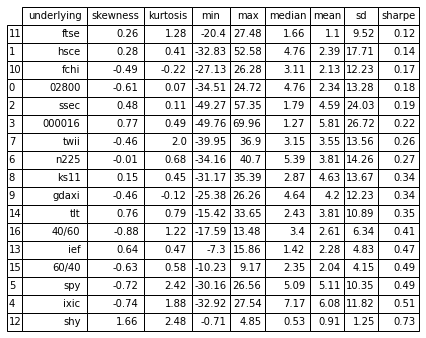

In [17]:
# 年度收益率
# df9 = df3.copy(deep=True) # year
df9 = df5.copy(deep=True) # semi-year
# df9 = df7.copy(deep=True) # quarterly

df9.index = df9['Date']
df9 = df9[['02800', 'hsce', 'ssec', '000016', 'ixic', 'spy', 'n225', 'twii', 'ks11', 'gdaxi', 'fchi', 'ftse', 'shy', 'ief', 'tlt']]
df9['60/40'] = np.nan
df9['40/60'] = np.nan
for k, v in df9.iterrows():
    df9.loc[k, '60/40'] = v['02800']*0.1982 + v['spy']*0.2018 + v['shy']*0.6
    df9.loc[k, '40/60'] = v['02800']*0.2974 + v['spy']*0.3026 + v['shy']*0.4

df9_2 = df9.copy(deep=True)
df9_2.insert(0, 'Date', df9_2.index.values)
df9_3 = draw_stats(data=df9_2, title=f'modern_portfolio_stats', scale_x=1.5, scale_y=1.5, is_show=False)

df9_1 = pd.DataFrame()
no = 0
for k, v in df9.iterrows():
    v1 = sorted(v.items(), key=lambda x: x[1], reverse=True)
    data9_1 = []
    for v2 in v1:
        data9_1.append(str(round(v2[1], 2))+' | '+v2[0])
    df9_1.insert(no, k, data9_1)
    no = no + 1

html_string = """
<html>
<style>
.dataframe {font-size: 12px; border-collapse: collapse;}
.dataframe th, .dataframe td {border: 1px solid #dddddd;}
</style>
<body>
    """+df9_1.to_html()+"""
</body>
</html>
"""
# imgkit.from_string(html_string, 'styled_table.png')

color_map = {
    '40/60': '#66c2a5',
    '60/40': '#fc8d62',
    '': '#8da0cb',
    '': '#e78ac3',
    '': '#a6d854',
    '': '#ffd92f',
    '': '#e5c494',
    '': '#b3b3b3'
}

def color_background(v):
    v1 = v.split('|')[1].replace(' ', '')
    if v1 in color_map:
        return f'font-size: 8pt; background-color: {color_map[v1]}'
    else:
        return 'font-size: 8pt;'

df9_1 = df9_1.style.applymap(color_background)
df9_1 = df9_1.set_table_styles([{'selector': 'th', 'props': [('font-size', '8pt'), ('min-width', '60pt')]}])
imgkit.from_string(df9_1.render(), 'modern_portfolio.png')
df9_1